In [ ]:
%pip install -q --force-reinstall airavata-python-sdk[notebook]
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC1:cloud,expanse:shared,anvil:shared
%switch_runtime hpc_cpu

# Exploring `temporaldata`

Notebook author: Mehdi Azabou | Contributions: Vinam Arora, Shivashriganesh Mahato, Eva Dyer

***

In this notebook, we will go through an example for preparing a dataset using
data objects from **temporaldata**, which we will learn to manipulate. Then, we will learn how to use samplers from **torch_brain** as part of a deep learning workflow.

The notebook is organized around three main concepts:
- **Part 1: Data**
- **Part 2: Dataset and slicing**
- **Part 3: Samplers**

Documentation:
- [**temporaldata**](https://temporaldata.readthedocs.io)
- [**torch_brain**](https://torch-brain.readthedocs.io)



***

## Part 1: Data

In part 1, we will learn about temporal data objects, and go through the process of preparing a dataset.

***

## Table of contents:
* [1.1 Overview of **temporaldata**](#a)
* [1.2 Downloading a recording from DANDI](#c)
* [1.3 Data Objects in temporaldata](#d)
* [1.4 Bringing it all together: Data](#e)
* [1.5 Saving data to disk](#f)


***

## 1.1 Overview of **temporaldata** <a class="anchor" id="a"></a>

<img src="https://temporaldata.readthedocs.io/en/latest/_static/temporaldata_logo.png" width="150" height="150" alt="temporaldata Logo">

[Documentation](https://temporaldata.readthedocs.io)

**temporaldata** is a Python package designed for deep learning workflows. It provides data abstractions for multi-modal, multi-resolution temporal data that are both intuitive and efficient. You can install it using pip.


#### Motivation:
- Temporal data in the real world is messy, and usually involves multiple multi-modal streams of data, recorded across different sensors. An example of this is neural recordings, where brain activity and behavior are typically recorded simultaneously. Such datasets often consist of a combination of **regular** and **irregular** time series.


In [ ]:
! dandi download dandi://dandi/000688@draft/sub-T/sub-T_ses-CO-20130819_behavior+ecephys.nwb

We will use a sessions from [1]. The monkey is performing a center-out task, where it makes a reach to one of eight fixed targets after receiving a go cue, and then returning to the center.

<img src="https://ik.imagekit.io/7tkfmw7hc/tbrain_notebooks/mp_image.png?updatedAt=1744132572759" width="300" alt="temporaldata Logo">

---

[1] Perich, Matthew G.; Miller, Lee E.; Azabou, Mehdi; Dyer, Eva L. (2025) Long-term recordings of motor and premotor cortical spiking activity during reaching in monkeys (Version 0.250122.1735) [Data set]. DANDI Archive. https://doi.org/10.48324/dandi.000688/0.250122.1735

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

#### Define plotting utils

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
import numpy as np

from bokeh.models import Button
from bokeh.models.callbacks import CustomJS
from bokeh.layouts import row, column

output_notebook()

def plot_spikes(spikes, add_range_tool=False, x_range=None, width=800, height=400):
    """
    Plots an IrregularTimeSeries object defined by spikes.timestamps and spikes.unit_index.

    Parameters:
    spikes: An object containing 'timestamps' and 'unit_index' attributes.
    """
    if x_range is None:
        if add_range_tool:
            x_range = (spikes.timestamps[0] * 1e3, spikes.timestamps[0] * 1e3 + 20_000)
        else:
            x_range = (spikes.timestamps[0] * 1e3, spikes.timestamps[-1] * 1e3)

    # Create a figure
    p = figure(x_axis_label='Time', y_axis_label='Unit Index', width=width, height=height, x_axis_type="datetime", x_range=x_range, title="Spikes")

    # Prepare data for plotting
    x_values = spikes.timestamps * 1e3
    y_values = spikes.unit_index

    # Create a ColumnDataSource
    source = ColumnDataSource(data=dict(x=x_values, y=y_values))

    # Add scatter points to the plot
    p.scatter('x', 'y', source=source, size=5, color="navy", alpha=0.5, marker="dash", angle=np.pi/2)

    if add_range_tool:
        select = figure(height=height//5, width=width, tools="",
                        toolbar_location=None, background_fill_color="#efefef", x_axis_type="datetime",
                        title="Average Population Activity")
        select.xaxis.visible = False
        # select.yaxis.visible = False

        range_tool = RangeTool(x_range=p.x_range)
        range_tool.overlay.fill_color = "navy"
        range_tool.overlay.fill_alpha = 0.2

        spike_times_int = spikes.timestamps.astype(int)
        population_activity =np.bincount(spike_times_int-spike_times_int[0])
        source = ColumnDataSource(data=dict(x=(np.arange(len(population_activity)) + spike_times_int[0])* 1e3, y=population_activity))

        select.line('x', 'y', source=source)
        select.ygrid.grid_line_color = None
        select.add_tools(range_tool)
        p = column(select, p)

    return p

def plot_time_series(data, field, index=None, x_range=None, add_range_tool=False, y_axis_label=None, width=800, height=200, include_control_panel=False, shade_area_list=[]):
    # Create a figure
    if x_range is None:
        if add_range_tool:
            x_range = (data.timestamps[0] * 1e3, data.timestamps[0] * 1e3 + 20_000)
        else:
            x_range = (data.timestamps[0] * 1e3, data.timestamps[-1] * 1e3)

    if y_axis_label is None:
        y_axis_label = field

    p = figure(x_axis_label='Time', y_axis_label=y_axis_label, width=width, height=height, x_axis_type="datetime", x_range=x_range)


    domain_start = data.domain.start * 1e3
    domain_end = data.domain.end * 1e3
    # Prepare data for plotting
    x_values = data.timestamps * 1e3
    y_values = getattr(data, field)

    x_values = np.concatenate([x_values, domain_start, domain_end])
    y_values = np.concatenate([y_values, np.nan * np.ones((len(data.domain), * y_values.shape[1:])), np.nan * np.ones((len(data.domain), *y_values.shape[1:]))])

    # sort x_values and reorder y_values
    sort_indices = np.argsort(x_values)
    x_values = x_values[sort_indices]
    y_values = y_values[sort_indices]

    if y_values.ndim == 1:
        # Add a line to the plot
        source = ColumnDataSource(data=dict(x=x_values, y=y_values))
    elif y_values.ndim == 2:
        assert index is not None, "Index must be provided for 2D data"
        source = ColumnDataSource(data=dict(x=x_values, y=y_values[:, index]))
    else:
        raise ValueError(f"Field {field} has {y_values.ndim} dimensions, expected 1 or 2")

    p.line(x='x', y='y', source=source, line_width=2, color="green")
    x_range = p.x_range

    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'black']
    for i, shade_area in enumerate(shade_area_list):
        start = shade_area.start * 1e3
        end = shade_area.end * 1e3
        rect_x = (start + end)/2
        rect_width = end - start
        rect_y = np.ones_like(start) * (y_values.min() + y_values.max())/2
        rect_height = np.ones_like(start) * (y_values.max() - y_values.min())
        p.rect(x=rect_x, y=rect_y, width=rect_width, height=rect_height, fill_color=colors[i], fill_alpha=0.4)
        # legend_items.append((f"Shade Area {i+1}", [p.renderers[-1]]))  # Add the rectangle to the legend items

    # p.legend.items = legend_items
    # p.legend.location = "top_left"  # Set the legend location
    # p.legend.click_policy = "hide"  # Allow clicking to hide the legend items

    if add_range_tool:
        select = figure(height=height//5, width=width, y_range=p.y_range, tools="",
                        toolbar_location=None, background_fill_color="#efefef", x_axis_type="datetime",)
        select.xaxis.visible = False
        select.yaxis.visible = False

        range_tool = RangeTool(x_range=p.x_range)
        range_tool.overlay.fill_color = "navy"
        range_tool.overlay.fill_alpha = 0.2

        select.line('x', 'y', source=source)
        select.ygrid.grid_line_color = None
        select.add_tools(range_tool)
        p = column(select, p)

        if include_control_panel:
            # Add a button to control the range tool
            play_button = Button(label="Play", button_type="success")
            pause_button = Button(label="Pause", button_type="warning")
            speed_buttons = [Button(label=f"{2**i}x", button_type="primary") for i in range(5)]

            # Create a shared ColumnDataSource to store the interval ID
            shared_data = ColumnDataSource(data=dict(interval_id=[None], step_size=[1000]))

            # Update the CustomJS to use the shared data source
            play_button.js_on_click(CustomJS(args=dict(range_tool=range_tool, x_values=x_values, shared_data=shared_data), code="""
                // Clear previous interval if it exists
                if (shared_data.data.interval_id[0]) {
                    clearInterval(shared_data.data.interval_id[0]);
                }

                // Create new interval and store it in the shared data
                let new_interval = setInterval(() => {
                    if (range_tool.x_range.end < x_values[x_values.length - 1]) {
                        range_tool.x_range.start += shared_data.data.step_size[0] / 10;
                        range_tool.x_range.end += shared_data.data.step_size[0] / 10;
                    } else {
                        clearInterval(shared_data.data.interval_id[0]);
                        shared_data.data.interval_id[0] = null;
                        shared_data.change.emit();
                    }
                }, 100);

                shared_data.data.interval_id[0] = new_interval;
                shared_data.change.emit();
            """));

            pause_button.js_on_click(CustomJS(args=dict(shared_data=shared_data), code="""
                if (shared_data.data.interval_id[0]) {
                    clearInterval(shared_data.data.interval_id[0]);
                    shared_data.data.interval_id[0] = null;
                    shared_data.change.emit();
                }
            """));

            for button in speed_buttons:
                button.js_on_click(CustomJS(args=dict(button=button, shared_data=shared_data), code="""
                    shared_data.data.step_size[0] = 1000 * parseInt(button.label.replace('x', ''));
                    shared_data.change.emit();
                """));

            # Add the buttons to the layout
            button_layout = row(play_button, pause_button, *speed_buttons)
            return p, x_range, button_layout

    return p


def plot_intervals(*interval, x_range=None, title=None, width=800, height=200):
    colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "black"]
    # Create a figure
    if x_range is None:
      p = figure(title=title, x_axis_label='Time', y_axis_label='Intervals', y_range=(-len(interval), 1), width=width, height=height, x_axis_type="datetime",)
    else:
      p = figure(title=title, x_axis_label='Time', x_range=x_range, y_axis_label='Intervals', y_range=(-len(interval), 1), width=width, height=height, x_axis_type="datetime",)

    p.yaxis.visible = False

    for i in range(len(interval)):
        # Prepare data for plotting
        centers = (interval[i].start + interval[i].end) / 2.  * 1e3
        durations = (interval[i].end - interval[i].start)  * 1e3
        y_values = np.zeros_like(centers) - i  # y-values for the intervals

        # Create a ColumnDataSource
        source = ColumnDataSource(data=dict(x=centers, width=durations, y=y_values))

        # Add rectangles to the plot
        p.rect(x='x', y='y', width='width', height=0.8, source=source, fill_color=colors[i % 10], line_color="black", alpha=0.5)

    return p

def make_plot(data, add_play_controls=False):
    include_control_panel = add_play_controls
    if include_control_panel:
      p_cursor_pos_x, x_range, button_layout = plot_time_series(data.cursor, 'vel', y_axis_label='cursor position x', index=0, add_range_tool=include_control_panel, include_control_panel=include_control_panel, shade_area_list=[data.domain])
    else:
      p_cursor_pos_x = plot_time_series(data.cursor, 'vel', y_axis_label='cursor position x', index=0, add_range_tool=include_control_panel, include_control_panel=include_control_panel, shade_area_list=[data.domain])
      x_range=p_cursor_pos_x.x_range

    p_cursor_pos_y = plot_time_series(data.cursor, 'vel', y_axis_label='cursor position y', index=1, add_range_tool=include_control_panel, x_range=x_range, shade_area_list=[data.reach_intervals])
    p_cursor_vel_x = plot_time_series(data.cursor, 'vel', y_axis_label='cursor velocity x', index=0, add_range_tool=include_control_panel, x_range=x_range, shade_area_list=[data.reach_intervals])
    p_cursor_vel_y = plot_time_series(data.cursor, 'vel', y_axis_label='cursor velocity y', index=1, add_range_tool=include_control_panel, x_range=x_range, shade_area_list=[data.reach_intervals])
    p_spikes = plot_spikes(data.spikes, add_range_tool=include_control_panel, x_range=x_range, height=480)
    p_reach_intervals = plot_intervals(data.reach_intervals, x_range=x_range, height=120, title="Reach intervals")

    if include_control_panel:
      return column(button_layout, row(p_spikes, column(p_reach_intervals, p_cursor_vel_x, p_cursor_vel_y)))
    else:
      return row(p_spikes, column(p_reach_intervals, p_cursor_vel_x, p_cursor_vel_y))


#### Visualizing the data

Below, we can visualize the data. We can see the simultanously recorded spiking activity and the corresponding cursor velocity. Press "Play" to start playing the recording back.

In [ ]:
#@title Visualizing the data

def plot_data():
  from pynwb import NWBHDF5IO
  import numpy as np
  from temporaldata import ArrayDict, IrregularTimeSeries, RegularTimeSeries, Interval, Data

  input_file = "sub-T_ses-CO-20130819_behavior+ecephys.nwb"
  io = NWBHDF5IO(input_file, "r")
  nwbfile = io.read()

  spike_train_list = nwbfile.units.spike_times_index[:]

  unit_ids = []
  unit_brain_areas = []
  for i in range(len(spike_train_list)):
      unit_ids.append(f"unit_{i}")
      unit_brain_areas.append(nwbfile.units.electrodes[i].location.item())
  units = ArrayDict(id=np.array(unit_ids), brain_area=np.array(unit_brain_areas))

  spike_timestamps = np.array([])
  spike_unit_index = np.array([])

  for i in range(len(spike_train_list)):
      spike_train = spike_train_list[i]
      spike_timestamps = np.concatenate([spike_timestamps, spike_train])
      spike_unit_index = np.concatenate([spike_unit_index, np.full_like(spike_train, fill_value=i)])

  spikes = IrregularTimeSeries(
      timestamps=spike_timestamps,
      unit_index=spike_unit_index,
      domain="auto",
  )
  spikes.sort()

  timestamps = nwbfile.processing["behavior"]["Position"]["cursor_pos"].timestamps[:]
  cursor_pos = nwbfile.processing["behavior"]["Position"]["cursor_pos"].data[:]
  cursor_vel = nwbfile.processing["behavior"]["Velocity"]["cursor_vel"].data[:]
  cursor_acc = nwbfile.processing["behavior"]["Acceleration"]["cursor_acc"].data[:]

  sampling_rate = 100 # Hz
  assert np.allclose(np.diff(timestamps), 1/sampling_rate)

  cursor = RegularTimeSeries(
      pos=cursor_pos,
      vel=cursor_vel,
      acc=cursor_acc,
      sampling_rate=sampling_rate,
      domain_start=timestamps[0],
      domain="auto",
  )

  trial_table = nwbfile.trials.to_dataframe().dropna()
  reach_intervals = Interval(
      start=trial_table.go_cue_time.values,
      end=trial_table.stop_time.values,
      result=trial_table.result.values,
      target_id=trial_table.target_id.values,
  )

  data = Data(
    spikes=spikes,
    cursor=cursor,
    reach_intervals=reach_intervals,
    domain="auto",
  )

  p = make_plot(data, add_play_controls=True)
  show(p)

plot_data()


The data was loaded using **temporaldata** objects. In this part of the tutorial, we will walk through how to prepare the data using various abstractions, that make data manipulation much more natural and efficient.

*Download the data from DANDI as NWB file*

The data is stored in an NWB file. The Neurodata Without Borders (NWB) format is a standardized, open-source file format designed to store neurophysiology data, including electrophysiology, and behavioral information.
We will use the `pynwb` library to load the data.

In [ ]:
from pynwb import NWBHDF5IO

input_file = "sub-T_ses-CO-20130819_behavior+ecephys.nwb"
io = NWBHDF5IO(input_file, "r")
nwbfile = io.read()

# we can access the spike times and unit indices directly from the NWB file
spike_train_list = nwbfile.units.spike_times_index[:]
print(f"Number of units found: {len(spike_train_list)}")

## 1.3. Data Objects in temporaldata

We now introduce the main data objects in temporal data:
- ArrayDict
- IrregularTimeSeries
- RegularTimeSeries
- Interval

### 1.3.1 Using **ArrayDict** to define the unit table <a class="anchor" id="c"></a>

The `ArrayDict` is a simple container for numpy arrays that share the same first dimension.
We can use this object to store the list of units including their identifiers (`id`) and brain areas (`brain_area`).

In [ ]:
import numpy as np
from temporaldata import ArrayDict

unit_ids = []
unit_brain_areas = []

# loop over the units
for i in range(len(spike_train_list)):
    unit_ids.append(f"unit_{i}")  # we will name the units as unit_0, unit_1, etc.
    unit_brain_areas.append(nwbfile.units.electrodes[i].location.item())

# create the ArrayDict object for the units
units = ArrayDict(id=np.array(unit_ids), brain_area=np.array(unit_brain_areas))

print(f"Number of units: {len(units)}. Brain areas: {np.unique(units.brain_area)}")
print(f"units={units}")

### 1.3.2 Using **IrregularTimeSeries** for spikes

Next, we will create the `spikes` object which will store the spiking neural data.

- The `spike_train_list` we extracted from the NWB file is a list of numpy arrays, with each array containing the spike times for a single unit.
In **temporaldata**, we combine all spikes into a large array. Each spike is defined by two values: the timestamp and the unit index.

- Since the spiking data is irregular and sparse, we use the `IrregularTimeSeries` object to represent it. Instead of repeating the unit identifier (stored in `units.id`),
we will use unit indices, where the unit index corresponds to a number between `0` and `num_units - 1` and maps to the unit id in `units.id`.

- We will create the `spikes` object by looping over the spike trains and adding them to the `spike_timestamps` and `spike_unit_index` arrays. Then build our `IrregularTimeSeries` object.

In [ ]:
import numpy as np
from temporaldata import ArrayDict, IrregularTimeSeries

# initialize the arrays
spike_timestamps = np.array([], dtype=np.float64)
spike_unit_index = np.array([], dtype=np.uint32)

# loop over the spike trains and add them to the arrays
for i in range(len(spike_train_list)):
    spike_train = spike_train_list[i]
    spike_timestamps = np.concatenate([spike_timestamps, spike_train])
    spike_unit_index = np.concatenate([spike_unit_index, np.full_like(spike_train, fill_value=i, dtype=np.uint32)])

# create the IrregularTimeSeries object
spikes = IrregularTimeSeries(
    timestamps=spike_timestamps,
    unit_index=spike_unit_index,
    domain="auto",
)
# sort the spikes by timestamps
spikes.sort()

print(f"Number of spikes: {len(spikes)}")
print(f"spikes={spikes}")


<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
fig = plot_spikes(spikes, width=1200)
show(fig)

### 1.3.3 Using RegularTimeSeries for cursor data

But next, we will create a `RegularTimeSeries` object to store the cursor position, velocity, and acceleration.
A `RegularTimeSeries` represents uniformly sampled time series data. Unlike the `IrregularTimeSeries`, we do not need
 to provide timestamps as they are inferred from the sampling rate and the first timestamp in the recording.


In [15]:
from temporaldata import RegularTimeSeries

timestamps = nwbfile.processing["behavior"]["Position"]["cursor_pos"].timestamps[:]
cursor_pos = nwbfile.processing["behavior"]["Position"]["cursor_pos"].data[:]
cursor_vel = nwbfile.processing["behavior"]["Velocity"]["cursor_vel"].data[:]
cursor_acc = nwbfile.processing["behavior"]["Acceleration"]["cursor_acc"].data[:]

sampling_rate = 100 # Hz
assert np.allclose(np.diff(timestamps), 1/sampling_rate)

cursor = RegularTimeSeries(
    pos=cursor_pos,
    vel=cursor_vel,
    acc=cursor_acc,
    sampling_rate=sampling_rate,
    domain_start=timestamps[0],
    domain="auto",
)

Let's visualize the cursor position.

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
fig = plot_time_series(cursor, field="pos", index=0, width=1200)
show(fig)

### 1.3.4 Using Interval for the trial table

The last object we will learn about in this tutorial is the `Interval` object.

An `Interval` is a set of time intervals each defined by a start time and an end time, and that can have additional fields describing the intervals.

We can extract the reach intervals, which are the time intervals between the go cue time and the time the movement stops.

In [17]:
from temporaldata import Interval

trial_table = nwbfile.trials.to_dataframe().dropna()
reach_intervals = Interval(
    start=trial_table.go_cue_time.values,
    end=trial_table.stop_time.values,
    result=trial_table.result.values,
    target_id=trial_table.target_id.values,
)

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
fig = plot_intervals(reach_intervals, width=1200)
show(fig)

## 1.4 Bringing it all together: Data

All streams of data can be stored in a `Data` object, which is a container for multiple **temporaldata** objects.

In [ ]:
from temporaldata import Data

data = Data(
    spikes=spikes,
    units=units,
    cursor=cursor.to_irregular(),
    reach_intervals=reach_intervals,
    domain="auto",
    # add metadata
    brainset=Data(id="perich_miller_population_2018"),
    session=Data(id="t_20130819_center_out_reaching"),
)

print(data)

In [ ]:
show(make_plot(data, add_play_controls=True))

## 1.5 Saving data to disk
**temporaldata** allows you to save files in hdf5 format

In [21]:
import h5py
import os

recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
os.makedirs("perich_miller_population_2018/", exist_ok=True)

# Save to file to h5
with h5py.File(f"{recording_id}.h5", "w") as f:
    data.to_hdf5(f)

## Part 2: Slicing data

***

## Table of contents:
* [2.1 Slicing an IrregularTimeSeries object](#aa)
* [2.2 Slicing a Data object](#bb)

***

Training models often requires repeatedly accessing small segments of data randomly scattered across large datasets—extracting just a few seconds from hours of recordings. **temporaldata** has the following features:
- easily slice through multi-modal data using only start and end times.
- efficiently load just the data you need when you need it.

Let's start with the first feature: slicing. Every temporal object in **temporaldata** has a `slice` method that can be called with two arguments: `start` and `end`. It returns an object of the same class but restricted to the data points within the `[start , end]` range.

<center>
<img src="https://ik.imagekit.io/7tkfmw7hc/tbrain_notebooks/slicing.png?updatedAt=1744132610041" width="1000"/>
</center>


### 2.1 Slicing an IrregularTimeSeries object
Let's take a look at what this looks like for `spikes`.

In [ ]:
spikes_sliced = spikes.slice(start=0., end=10.)

print(f"Before slicing:\nspikes={spikes}")
print(f"After slicing:\nspikes_sliced={spikes_sliced}")

The returned object is another `IrregularTimeSeries` object, but only contains spike events between `start` and `end`.

Let's plot the sliced object.

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
fig = plot_spikes(spikes_sliced, width=1200)
fig.title = f"Spikes between {spikes_sliced.domain.start[0]}s and {spikes_sliced.domain.end[0]}s"
show(fig)

***
### 2.2 Slicing a Data object

More generally, a recording is represented by a multi-modal `Data` object. When `slice` is called, all of its children are sliced accordingly, making the slicing and object manipulation seemless.

<img src="https://ik.imagekit.io/7tkfmw7hc/tbrain_notebooks/full_data_obj.png?updatedAt=1744132750893" width="1000">

In [ ]:
data_sliced = data.slice(start=20., end=100.)

In [ ]:
show(make_plot(data_sliced))

## Part 3: Dataset and Samplers

<img src="https://torch-brain.readthedocs.io/en/latest/_static/torch_brain_logo.png" width="150" height="150" alt="torch_brain Logo">

[Documentation](https://torch-brain.readthedocs.io)

**torch_brain** provides several tools on top of the **temporaldata** package to make it easier to work with temporal data in deep learning workflows. In this section, we will learn about the `Dataset` and `samplers` classes.

***

## Table of contents:
* [3.1 Overview of **torch_brain.data.Dataset**](#cc)
* [3.2 Overview of **torch_brain.data.samplers**](#aa)
* [3.3 Using sampling intervals](#bb)
* [3.4 Samplers in action](#cc)

***
### 3.1 torch_brain.data.Dataset

`torch_brain` provides a Dataset interface that allows to access a single or multiple recordings.

Data is never fully loaded into memory, but rather lazy-loaded on-the-fly from disk.
The lazy loading is done both in:
- time: only the requested time interval is loaded, without having to load the entire recording into memory, and
- attributes: attributes are not loaded until they are requested, this is useful when only a small subset of the attributes are actually needed.

The dataset can be indexed by a recording id and a start and end times using the get method.

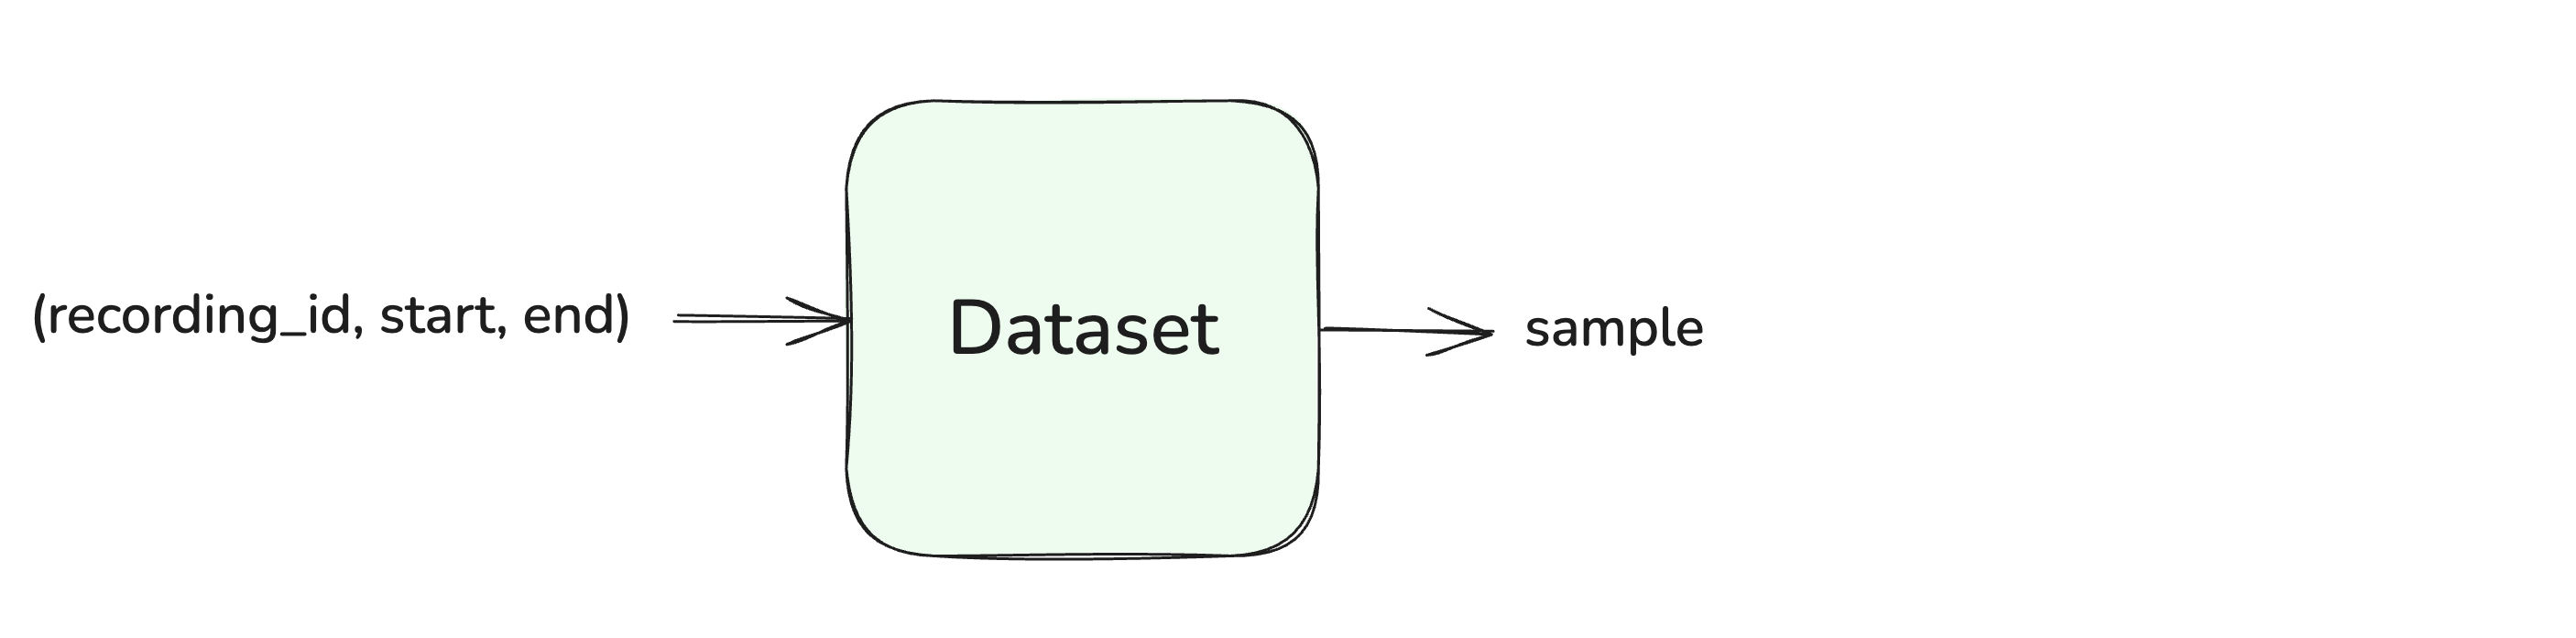

In [ ]:
from torch_brain.data import Dataset

recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
dataset = Dataset("./", recording_id=recording_id)

In [ ]:
data_sliced = dataset.get(recording_id, start=20, end=100)
show(make_plot(data_sliced))

### 3.2 Overview of torch_brain.data.samplers

The advanced sampling capabilities in torch_brain enable flexible and customizable data loading by allowing users to define arbitrary sampling intervals and window lengths for their neural data. This design makes it easy to handle complex experimental protocols with non-contiguous recording periods, while providing a simple interface that automatically handles the complexities of sampling from multiple intervals or sessions.

torch_brain provides a number of samplers that can be used to generate samples for training, or evaluation:

| Sampler | Description|
| - | - |
| SequentialFixedWindowSampler | A Sequential sampler, that samples fixed-length windows. |
| RandomFixedWindowSampler | A Random sampler, that samples fixed-length windows. |
| TrialSampler | A sampler that randomly samples a full contiguous interval without slicing it into windows. |


### 3.3 Using sampling intervals

Sampling intervals are the intervals from which a data sampler is allowed to sample data. The sampling intervals do not have to be contiguous, and can be of any length. They are defined as Interval objects with start and end times.

torch_brain provides a number of samplers that can be used to generate samples for training, or evaluation.

The most common sampler used in practice is the RandomFixedWindowSampler, which randomly samples windows of a fixed length from the data. We provide the sampling intervals in order to restrict where the sampler can sample from.

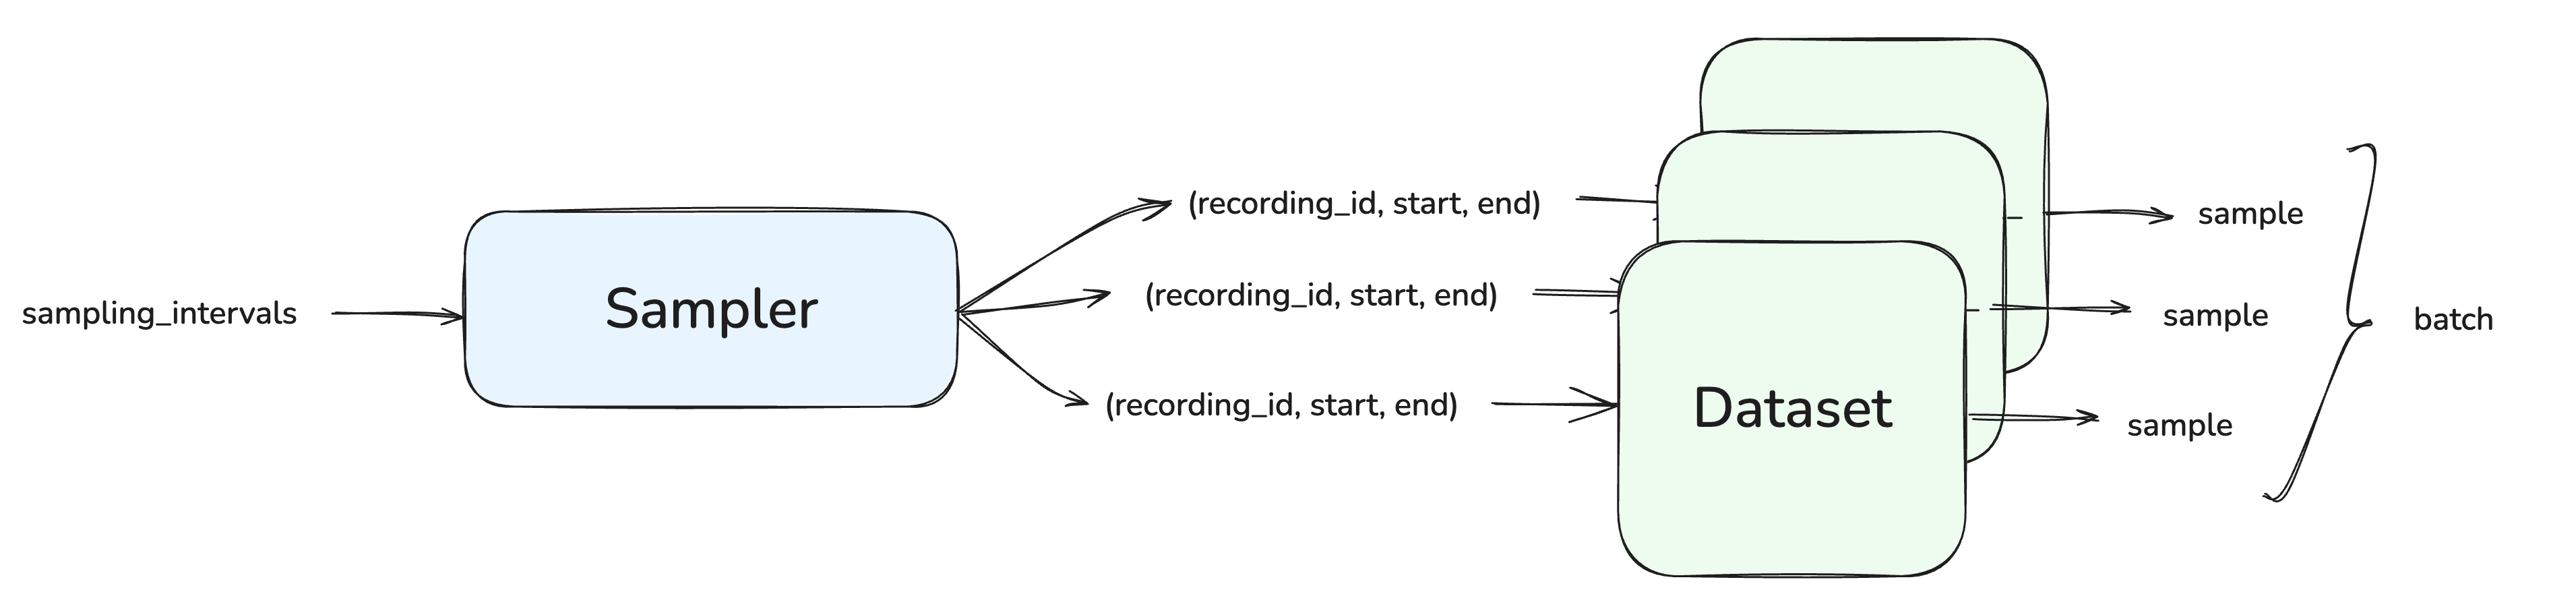

In [3]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Button, Div
from bokeh.models.callbacks import CustomJS
from bokeh.layouts import layout

def simulate_sampling_process(sampler):
  assert len(sampler.sampling_intervals) == 1
  sampling_intervals = list(sampler.sampling_intervals.values())[0]
  # Create single figure
  p = figure(
      width=800,
      height=300,
      x_axis_label="Time (s)",
      y_range=(0.0, 1.0),
      tools=["hover", "xwheel_zoom", "xpan", "reset"],
      active_scroll="xwheel_zoom",
  )
  p.x_range.bounds = (sampling_intervals.start[0] - 10, sampling_intervals.end[-1] + 10)

  # Remove horizontal grid lines while keeping vertical ones
  p.xgrid.grid_line_color = "#E5E5E5"
  p.ygrid.grid_line_color = None

  # Add hover tooltip only for sampled windows
  p.hover.tooltips = [("start", "@left{0.2f} s"), ("end", "@right{0.2f} s")]

  # Set axis limits with padding
  p.x_range.start = sampling_intervals.start[0] - 10
  p.x_range.end = sampling_intervals.end[-1] + 10
  # Remove y-axis ticks
  p.yaxis.visible = False

  # Plot original intervals
  intervals_data = {
      "left": sampling_intervals.start,
      "right": sampling_intervals.end,
      "top": 0.4 * np.ones_like(sampling_intervals.start),
      "bottom": 0.1 * np.ones_like(sampling_intervals.start),
  }
  intervals_source = ColumnDataSource(intervals_data)
  intervals = p.quad(
      top="top",
      bottom="bottom",
      left="left",
      right="right",
      color="gray",
      source=intervals_source,
      alpha=0.3,
      legend_label="Sampling Intervals",
  )

  # Create data source for sampled windows
  sampled_windows_data = {"left": [], "right": [], "top": [], "bottom": []}
  sampled_source = ColumnDataSource(sampled_windows_data)
  windows = p.quad(
      top="top",
      bottom="bottom",
      left="left",
      right="right",
      source=sampled_source,
      alpha=0.5,
      color="red",
      line_color="black",
      line_width=0.3,
      legend_label="Sampled Windows",
  )
  p.legend.click_policy = "hide"

  # Move legend outside of plot area and stack horizontally
  p.legend.location = "top_right"
  p.legend.click_policy = "hide"
  p.legend.border_line_color = None
  p.legend.background_fill_alpha = 0
  p.legend.orientation = "horizontal"
  # p.add_layout(p.legend[0], 'above')


  def sample_windows(sampler):
      sampled_windows = []
      sampler_iter = iter(sampler)
      for _ in range(len(sampler)):
          try:
              idx = next(sampler_iter)
              sampled_windows.append({"start": idx.start, "end": idx.end})
          except StopIteration:
              break
      return sampled_windows


  num_samples = len(sampler)


  # Sample windows upfront
  sampled_windows_1 = sample_windows(sampler)
  sampled_windows_2 = sample_windows(sampler)
  sampled_windows_3 = sample_windows(sampler)

  # Add controls
  div = Div(
      text="""<p>Click the Generate samples button to start sampling windows of 1s.</p>""",
      width=400,
      # height=30,
  )

  # Create auto-play callback
  auto_callback = CustomJS(
      args={
          "source": sampled_source,
          "windows_1": sampled_windows_1,
          "windows_2": sampled_windows_2,
          "windows_3": sampled_windows_3,
          "current_windows": sampled_windows_1.copy(),  # Start with first set
          "button": None,  # Add button reference that will be updated later
      },
      code="""
      // Disable button while playing
      button.disabled = true;

      // Clear existing windows
      source.data['left'] = [];
      source.data['right'] = [];
      source.data['top'] = [];
      source.data['bottom'] = [];
      source.change.emit();

      // Initialize window set if not already set
      if (!button.window_set) {
          button.window_set = 1;
      }

      function playNextWindow() {
          if (current_windows.length > 0) {
              var window = current_windows.shift();  // Remove and get first window

              var data = source.data;
              data['left'].push(window.start);
              data['right'].push(window.end);
              data['top'].push(0.8);
              data['bottom'].push(0.5);

              source.change.emit();

              setTimeout(playNextWindow, 10);
          } else {
              // All windows played - prepare for next seed
              button.disabled = false;

              if (button.window_set === 1) {
                  current_windows.push.apply(current_windows, windows_2);
                  button.window_set = 2;
                  button.label = 'Generate samples for epoch 2';
              } else if (button.window_set === 2) {
                  current_windows.push.apply(current_windows, windows_3);
                  button.window_set = 3;
                  button.label = 'Generate samples for epoch 3';
              } else {
                  current_windows.push.apply(current_windows, windows_1);
                  button.window_set = 1;
                  button.label = 'Generate samples for epoch 1';
              }
          }
      }

      // Start playing windows
      playNextWindow();
  """,
  )

  auto_button = Button(
      label="Generate samples for epoch 1", button_type="primary", width=100
  )
  auto_callback.args["button"] = auto_button

  # Enable HTML rendering for the label
  auto_button.css_classes = ["fa-button"]
  auto_button.js_on_click(auto_callback)

  # Create layout and show
  show(layout([[div], [auto_button], [p]]))


### 3.3 Samplers in action

We can visualize what the sampler is doing as we are iterating over it.

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
from torch_brain.data.sampler import RandomFixedWindowSampler

sampling_intervals = {recording_id: data.domain}

sampler = RandomFixedWindowSampler(
    sampling_intervals=sampling_intervals,
    window_length=10.0,
)

simulate_sampling_process(sampler)

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
sampling_intervals = {recording_id: data.reach_intervals}

sampler = RandomFixedWindowSampler(
    sampling_intervals=sampling_intervals,
    window_length=0.5,
)

simulate_sampling_process(sampler)

#### Spliting the data to train/val/test

Typically, data is split into train, validation and test. In `torch_brain` this is also done through sampling_intervals.

Below we are going to use `Interval.linspace` and `Interval.split`, please refer to the documentation of both methods.

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">


In [ ]:
# split the recording into 20 blocks
grid = Interval.linspace(start=data.domain.start[0], end=data.domain.end[-1], steps=20)

train_intervals, valid_intervals, test_intervals = grid.split([0.6, 0.2, 0.2], shuffle=False)

p = plot_intervals(train_intervals, valid_intervals, test_intervals)
show(p)

We can also choose to randomly shuffle the different blocks

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
train_intervals, valid_intervals, test_intervals = grid.split([0.6, 0.2, 0.2], shuffle=True)

p = plot_intervals(train_intervals, valid_intervals, test_intervals)
show(p)

`train_intervals`, `valid_intervals` and `test_intervals` are all `Interval` objects that can be used as `sampling_intervals`:

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
sampling_intervals = {recording_id: train_intervals}
sampler = RandomFixedWindowSampler(
    sampling_intervals=sampling_intervals,
    window_length=10.0,
)

simulate_sampling_process(sampler)

Finally, to restrict sampling to the training intervals and the intervals corresponding to the reaching movement, we can use interval operations.

Documentation: https://temporaldata.readthedocs.io/en/latest/concepts/interval_operations.html

In this case, we want the intersection of `train_intervals` and `data.reach_intervals`, which is simply: `train_intervals & data.reach_intervals`

<img src="https://poyo-brain.github.io/assets/bk-tap.png" width="50" alt="This cell is interactive">

In [ ]:
train_reaching_intervals = train_intervals & data.reach_intervals

sampling_intervals = {recording_id: train_reaching_intervals}

sampler = RandomFixedWindowSampler(
    sampling_intervals=sampling_intervals,
    window_length=0.5,
)

simulate_sampling_process(sampler)